In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from secrets.con_str import con_str

# import warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)


engine = create_engine(con_str)

In [2]:
sql = """
-- Gets the group of parcels that intersect each footprint
WITH grouped_parcels AS (
	SELECT
		foot_gid,
		ST_Collect(array_agg(parcels.geom)) AS geoms
	FROM intersections
	JOIN parcels
	ON parcels.gid = intersections.parcel_gid
	GROUP BY foot_gid
),
-- Get the top ten messiest footprint intersections based on:
-- 1. intersects multiple parcels
-- 2. largest intersection area that is:
--    a) less than 10%% of its parcel area
--    a) less than 10%% of its footprint area
-- 
-- In other words, find the biggest intersections that are
-- just a small piece of the parent footprint and parent parcel
-- and return that footprint and the parcels that divide it.
weird_intersections AS (
	-- Gets footprints that intersect more than one parcel
	WITH divided_foots AS (
		SELECT foot_gid
		FROM intersections_reduced
		GROUP BY foot_gid
		HAVING COUNT(*) > 1
	)
	SELECT intersections_reduced.foot_gid
	FROM intersections_reduced
	INNER JOIN divided_foots
	ON divided_foots.foot_gid = intersections_reduced.gid
	WHERE area/foot_area < 0.1
	AND area/parcel_area < 0.1
	ORDER BY area DESC
	LIMIT 20)
SELECT
  footprints.gid,
	ST_Collect(
    footprints.geom,
	  grouped_parcels.geoms
  ) AS geom
FROM weird_intersections
JOIN footprints
ON weird_intersections.foot_gid = footprints.gid
JOIN grouped_parcels
ON grouped_parcels.foot_gid = footprints.gid;
"""
messy_df = gpd.read_postgis(sql, engine)
messy_df.head()

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


,gid,geom
0,6293,GEOMETRYCOLLECTION (MULTIPOLYGON (((1281548.72...
1,6790,GEOMETRYCOLLECTION (MULTIPOLYGON (((1281356.74...
2,14219,GEOMETRYCOLLECTION (MULTIPOLYGON (((1282356.31...
3,20728,GEOMETRYCOLLECTION (MULTIPOLYGON (((1281731.85...
4,21234,GEOMETRYCOLLECTION (MULTIPOLYGON (((1281141.73...


/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

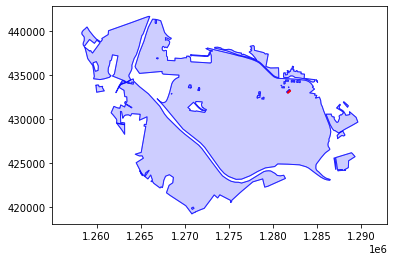

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

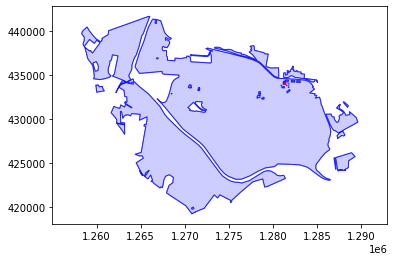

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

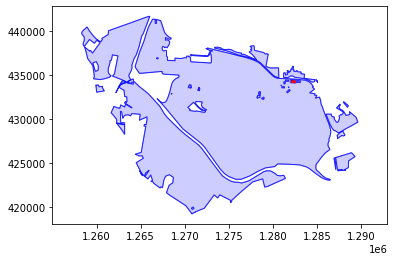

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

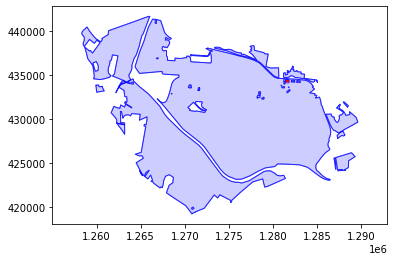

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

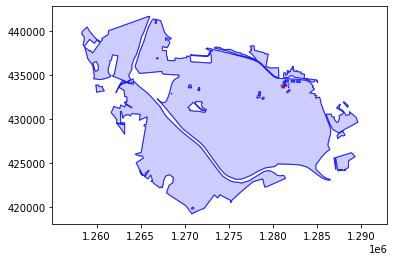

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

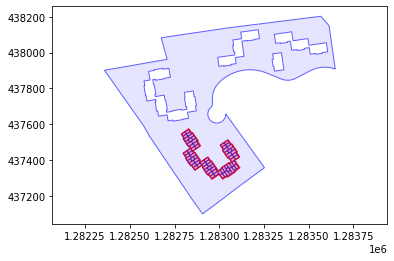

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

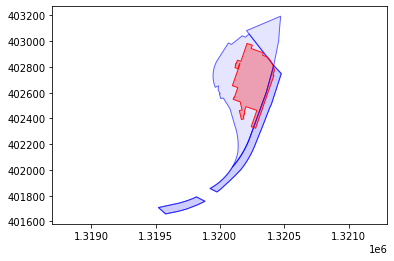

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

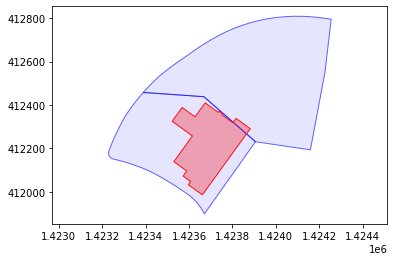

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

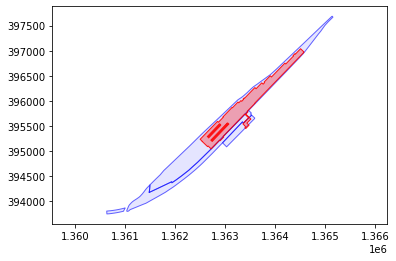

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

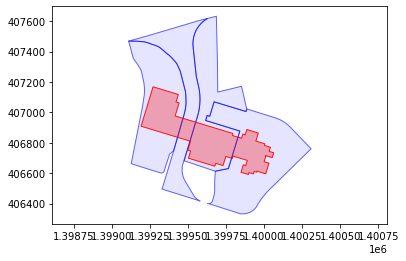

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

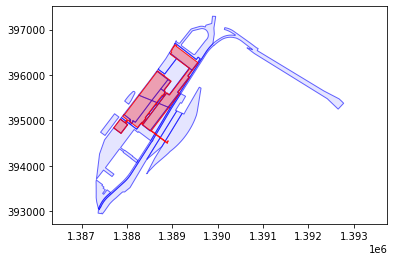

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

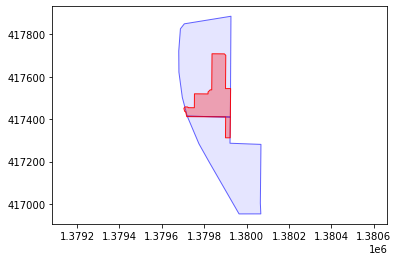

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

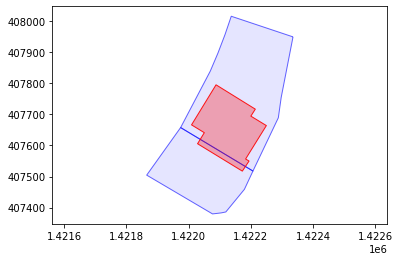

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

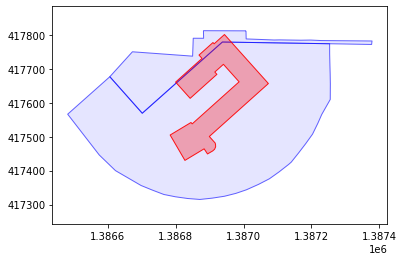

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

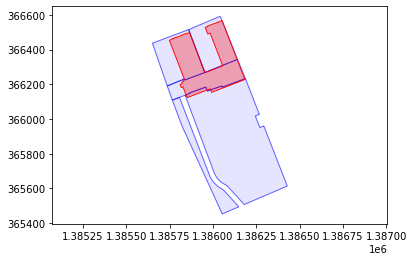

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

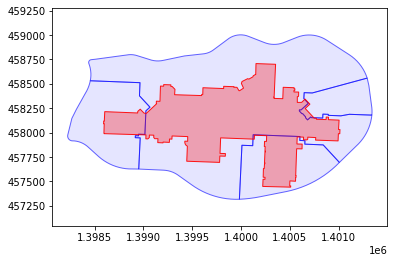

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

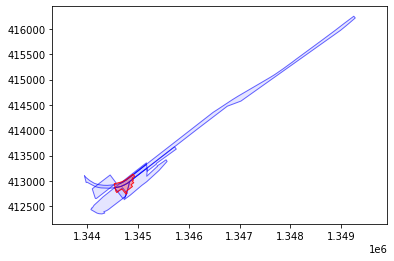

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

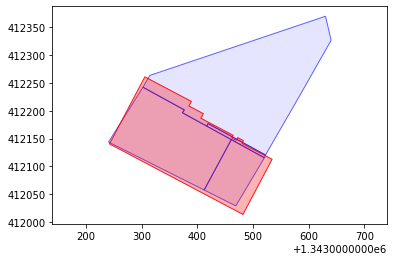

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

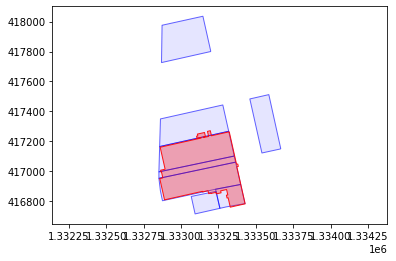

/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/Users/tom/opt/miniconda3/envs/geopandas_env2/lib/python3.9/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/

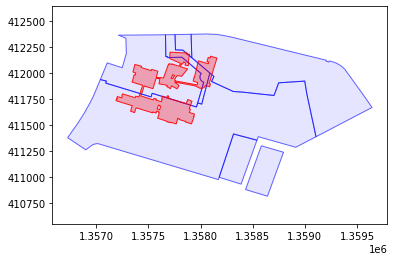

In [7]:
for geom_coll in messy_df['geom']:
  fig, ax = plt.subplots(1, 1)
  [footprint, parcels] = geom_coll.geoms
  
  gpd.GeoSeries(parcels).plot(ax=ax, color=(0,0,1,0.1), edgecolor=(0,0,1,0.6))
  gpd.GeoSeries(footprint).plot(ax=ax, color=(1,0,0,0.3), edgecolor=(1,0,0,0.9))
  
  plt.gca().axis("equal")
  plt.show()
  # foot_type = footprint.geom_type
  # for parcel in parcels.geoms:
  #   print(parcel.geom_type)